Author: Autumn Salsberry

Contact: linkedin.com/in/salsbeas

BrainStation Capstone: Predicting Adoptability of Shelter Dogs

August 8, 2022

The purpose of this notebook is to clean the image data, create a data frame that describes the images and explore if transfer learning could be used to accurately classify the 120 breeds represented in the Stanford Dogs dataset (20,580 images in total).

# Table of Contents

* [Cleaning the Image Data](#clean)
* [Transfer Learning](#tl) 
    * [VGG16 Model](#vgg)

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pathlib


from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Goal

* Correctly classify the breed of a dog in an image
    * Classify 120 dog breeds using transfer learning

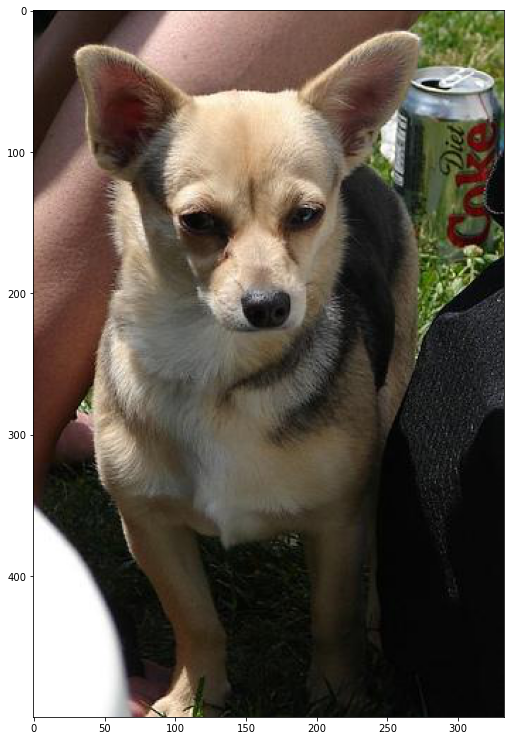

In [2]:
import imageio

#what does one of the images look like in the files?
example_image = imageio.imread('Image Data/Images/n02085620-Chihuahua/n02085620_10074.jpg')

plt.figure(figsize=(13,13))
plt.imshow(example_image)
plt.show()

# Cleaning the Image Data
<a class="anchor" id="clean"></a>

As is necessary with tabular data, image data must be in a specific format before it can be ran through different models. In this section I will split the images into train, validation and test sets that will be stored in separate folder located on my local computer. I then will resize the images so they are uniform and store these images in yet another folder. Finally, I will create a data frame to hold the key details about the image data. 

## Start Creating the Data Frame

In [3]:
import os

#read through the image data and collect the folder names
list_ = os.listdir("Image Data/Images") # dir is your directory path
number_files = len(list_)
print("There are ", number_files, " folders/categories")
print("The folder/category names are:")

categories = [name for name in os.listdir('Image Data/Images')]
categories

There are  120  folders/categories
The folder/category names are:


['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

In [4]:
#read through the folder count the number of images in each
    #note: breed is the name of the folder because the breed is included in the name
breeds = []
org_num_images = []
for breed in categories:
    breeds.append(breed)
    list_ = os.listdir(f"Image Data/Images/{breed}")
    number_files = len(list_)
    org_num_images.append(number_files)

info_df = pd.DataFrame({'breed': breeds, 'Num_images_org':org_num_images})
info_df.head()

,breed,Num_images_org
0,n02085620-Chihuahua,152
1,n02085782-Japanese_spaniel,185
2,n02085936-Maltese_dog,252
3,n02086079-Pekinese,149
4,n02086240-Shih-Tzu,214


In [5]:
#split the folder name to isolate the breed
info_df[['file_name','breed']] = info_df['breed'].str.split('-', n=1, expand=True)

In [6]:
#check for null values
info_df.isna().sum()

breed             0
Num_images_org    0
file_name         0
dtype: int64

In [7]:
#what is the fewest images a breed has
info_df[info_df['Num_images_org']<150]
#only 2 breeds with less than 150 images and they are close to 150, so no underrepresented dogs

,breed,Num_images_org,file_name
3,Pekinese,149,n02086079
17,redbone,148,n02090379


In [8]:
#what does the df look like so far
info_df.sample(5)

,breed,Num_images_org,file_name
64,Brittany_spaniel,152,n02101388
105,Great_Pyrenees,213,n02111500
42,Australian_terrier,196,n02096294
47,standard_schnauzer,155,n02097209
45,miniature_schnauzer,154,n02097047


In [9]:
#rename this column for clarity
info_df['total_images'] = info_df['Num_images_org']
info_df.drop('Num_images_org', axis=1, inplace=True)

In [10]:
#calculate the percentage of images of this dog compared to the total number of images
info_df['perc_total'] = round(info_df['total_images']/20580*100, 2)

info_df.head()

,breed,file_name,total_images,perc_total
0,Chihuahua,n02085620,152,0.74
1,Japanese_spaniel,n02085782,185,0.90
2,Maltese_dog,n02085936,252,1.22
3,Pekinese,n02086079,149,0.72
4,Shih-Tzu,n02086240,214,1.04


Below is the code I used to split the original image folder into 3 subfolders corresponding with train, val and test sets. I have commented it out because it is a long process and I do not want to delete and create empty folder sets repeatedly for this process. If you would like to do this, I suggestion setting aside a few minutes for it. 

In [11]:
#import splitfolders

## split the folders into train, val, and test sets
#splitfolders.ratio("Images", output="output",
   # seed=1337, ratio=(.4, .2, .4), group_prefix=None, move=False) # default values

#source: https://github.com/jfilter/split-folders

### Split - Train Set Exploration
After creating the split sets, I will go through the folders and collected information on the number of images in each folder and store this information in the data frame I started above. I will then check that the split accurately represents the proportions of each breed represented by calculating the percent of images in the train split folder compared with the original folder for that breed. For the train set, this should be approximately 40% of the total. 

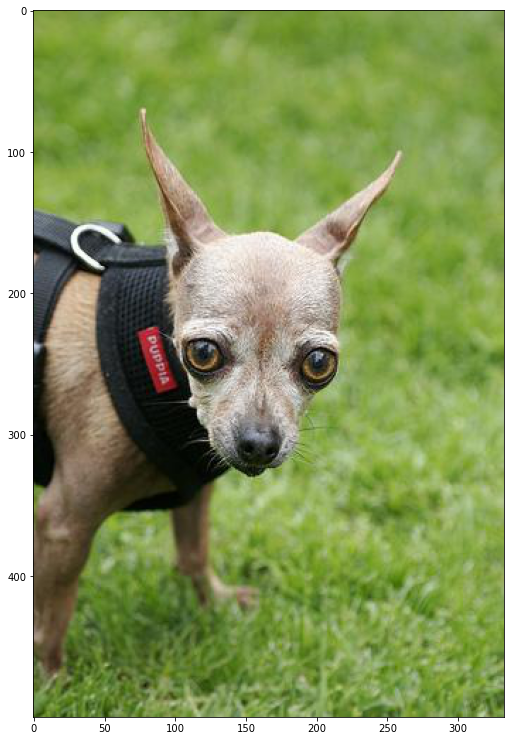

In [12]:
#did the spliting work properly?
example_image = imageio.imread('Image Data/output/train/n02085620-Chihuahua/n02085620_326.jpg')

plt.figure(figsize=(13,13))
plt.imshow(example_image)
plt.show()

In [13]:
#count the number of images in each subfolder
train_num_images = []
for breed in categories:
    list_ = os.listdir(f"Image Data/output/train/{breed}")
    number_files = len(list_)
    train_num_images.append(number_files)

#store those numbers in the df
info_df['train_images'] = train_num_images

In [14]:
#calculate the percent of total - should be ~40% for all
info_df['train_perc_total_original'] = round(info_df['train_images']/info_df['total_images']*100, 2)

In [15]:
#are any way below expected distibution?
info_df[info_df['train_perc_total_original']<39.49]

,breed,file_name,total_images,perc_total,train_images,train_perc_total_original
0,Chihuahua,n02085620,152,0.74,60,39.47
54,flat-coated_retriever,n02099267,152,0.74,60,39.47
59,German_short-haired_pointer,n02100236,152,0.74,60,39.47
64,Brittany_spaniel,n02101388,152,0.74,60,39.47
75,briard,n02105251,152,0.74,60,39.47
83,Rottweiler,n02106550,152,0.74,60,39.47
84,German_shepherd,n02106662,152,0.74,60,39.47
93,Tibetan_mastiff,n02108551,152,0.74,60,39.47


In [16]:
#are any above expected distibution?
info_df[info_df['train_perc_total_original']>40]

,breed,file_name,total_images,perc_total,train_images,train_perc_total_original


### Split - Validation Set Exploration

Similar to what I did for the train set, I will count the number of images in each subfolder and confirm that this distribution is proportional to expectation. This set should have ~20% of the whole. 

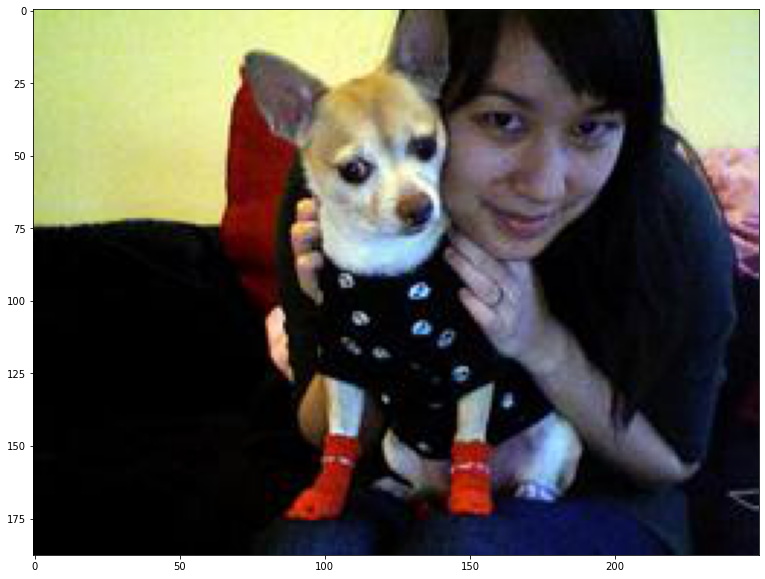

In [17]:
#are there any images in the subfolders?
example_image = imageio.imread('Image Data/output/val/n02085620-Chihuahua/n02085620_7.jpg')

plt.figure(figsize=(13,13))
plt.imshow(example_image)
plt.show()

In [18]:
#count how many images are in each sub folder
val_num_images = []
for breed in categories:
    list_ = os.listdir(f"Image Data/output/val/{breed}")
    number_files = len(list_)
    val_num_images.append(number_files)

#store those numbers in the df
info_df['validation_images'] = val_num_images

In [19]:
#calc the percent of images represented in each folder - should be 20%
info_df['val_perc_total_original'] = round(info_df['validation_images']/info_df['total_images']*100, 2)
info_df.head()

,breed,file_name,total_images,perc_total,train_images,train_perc_total_original,validation_images,val_perc_total_original
0,Chihuahua,n02085620,152,0.74,60,39.47,30,19.74
1,Japanese_spaniel,n02085782,185,0.90,74,40.00,37,20.00
2,Maltese_dog,n02085936,252,1.22,100,39.68,50,19.84
3,Pekinese,n02086079,149,0.72,59,39.60,29,19.46
4,Shih-Tzu,n02086240,214,1.04,85,39.72,42,19.63


In [20]:
#are any way below expected?
info_df[info_df['val_perc_total_original']<19.5]

,breed,file_name,total_images,perc_total,train_images,train_perc_total_original,validation_images,val_perc_total_original
3,Pekinese,n02086079,149,0.72,59,39.60,29,19.46
45,miniature_schnauzer,n02097047,154,0.75,61,39.61,30,19.48
60,vizsla,n02100583,154,0.75,61,39.61,30,19.48
72,schipperke,n02104365,154,0.75,61,39.61,30,19.48
77,komondor,n02105505,154,0.75,61,39.61,30,19.48


In [21]:
#are any greater than expected?
info_df[info_df['val_perc_total_original']>20]

,breed,file_name,total_images,perc_total,train_images,train_perc_total_original,validation_images,val_perc_total_original


### Split - Test Set Exploration

One more time to confirm the test split went well. It should represent 40% of the image data. 

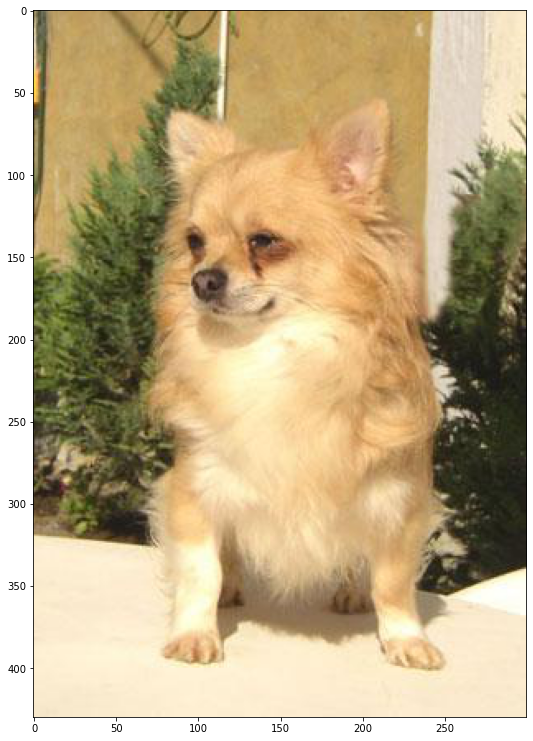

In [22]:
#is there anything in the subfolders
example_image = imageio.imread('Image Data/output/test/n02085620-Chihuahua/n02085620_199.jpg')

plt.figure(figsize=(13,13))
plt.imshow(example_image)
plt.show()

In [23]:
#coutn how many images are in the subfolders
test_num_images = []
for breed in categories:
    list_ = os.listdir(f"Image Data/output/test/{breed}")
    number_files = len(list_)
    test_num_images.append(number_files)

    #store those numbers in the df
info_df['test_images'] = test_num_images

In [24]:
#calculate the percent of images are in the subfolder compared to the total - should be 40%
info_df['test_perc_total_original'] = round(info_df['test_images']/info_df['total_images']*100, 2)
info_df.head()

,breed,file_name,total_images,perc_total,train_images,train_perc_total_original,validation_images,val_perc_total_original,test_images,test_perc_total_original
0,Chihuahua,n02085620,152,0.74,60,39.47,30,19.74,62,40.79
1,Japanese_spaniel,n02085782,185,0.90,74,40.00,37,20.00,74,40.00
2,Maltese_dog,n02085936,252,1.22,100,39.68,50,19.84,102,40.48
3,Pekinese,n02086079,149,0.72,59,39.60,29,19.46,61,40.94
4,Shih-Tzu,n02086240,214,1.04,85,39.72,42,19.63,87,40.65


In [25]:
#are any below 40%
info_df[(info_df['test_perc_total_original']<40)]

,breed,file_name,total_images,perc_total,train_images,train_perc_total_original,validation_images,val_perc_total_original,test_images,test_perc_total_original


In [26]:
#are any way above 40%
info_df[(info_df['test_perc_total_original']>41)]

,breed,file_name,total_images,perc_total,train_images,train_perc_total_original,validation_images,val_perc_total_original,test_images,test_perc_total_original


Alright, the three sets were accurately placed in three folders with class subfolders and they maintained their proper distribution of ratio of .4, .2, and .4 respectively. 

### Evaluating the Data Frame and Split Folders
Just for a final confirmation, I will add the percentages from each split across the classes to confirm that the train image percent plus the val image percent plus the test image percent all add to 100. 

In [27]:
#confirm the percentages add to 100% across the split
info_df['per_image'] = info_df['train_perc_total_original'] +info_df['val_perc_total_original']+info_df['test_perc_total_original']

In [28]:
#are any below 100?
info_df[info_df['per_image']<100]

,breed,file_name,total_images,perc_total,train_images,train_perc_total_original,validation_images,val_perc_total_original,test_images,test_perc_total_original,per_image
17,redbone,n02090379,148,0.72,59,39.86,29,19.59,60,40.54,99.99
29,American_Staffordshire_terrier,n02093428,164,0.80,65,39.63,32,19.51,67,40.85,99.99
32,Kerry_blue_terrier,n02093859,179,0.87,71,39.66,35,19.55,73,40.78,99.99
36,Yorkshire_terrier,n02094433,164,0.80,65,39.63,32,19.51,67,40.85,99.99
39,Sealyham_terrier,n02095889,202,0.98,80,39.60,40,19.80,82,40.59,99.99
40,Airedale,n02096051,202,0.98,80,39.60,40,19.80,82,40.59,99.99
51,soft-coated_wheaten_terrier,n02098105,156,0.76,62,39.74,31,19.87,63,40.38,99.99
53,Lhasa,n02098413,186,0.90,74,39.78,37,19.89,75,40.32,99.99
90,EntleBucher,n02108000,202,0.98,80,39.60,40,19.80,82,40.59,99.99
92,bull_mastiff,n02108422,156,0.76,62,39.74,31,19.87,63,40.38,99.99


In [29]:
#are any above 100?
info_df[info_df['per_image']>100]

,breed,file_name,total_images,perc_total,train_images,train_perc_total_original,validation_images,val_perc_total_original,test_images,test_perc_total_original,per_image
6,papillon,n02086910,196,0.95,78,39.80,39,19.90,79,40.31,100.01
9,Afghan_hound,n02088094,239,1.16,95,39.75,47,19.67,97,40.59,100.01
18,borzoi,n02090622,151,0.73,60,39.74,30,19.87,61,40.40,100.01
23,Norwegian_elkhound,n02091467,196,0.95,78,39.80,39,19.90,79,40.31,100.01
24,otterhound,n02091635,151,0.73,60,39.74,30,19.87,61,40.40,100.01
26,Scottish_deerhound,n02092002,232,1.13,92,39.66,46,19.83,94,40.52,100.01
42,Australian_terrier,n02096294,196,0.95,78,39.80,39,19.90,79,40.31,100.01
55,curly-coated_retriever,n02099429,151,0.73,60,39.74,30,19.87,61,40.40,100.01
69,Sussex_spaniel,n02102480,151,0.73,60,39.74,30,19.87,61,40.40,100.01
89,Appenzeller,n02107908,151,0.73,60,39.74,30,19.87,61,40.40,100.01


A few classes have 99.99% of images represented in the data. This is likely due to rounding error not actually missing any images. If some how an image did get lost in the split, it would not be statistically significant anyway. I will confirm that no images were lost though by adding the number counts of each subfolder across the split folders. For example, the number of chihuahua images in the train folder plus the number in the val folder plus the number in the test folder. These numbers should add to the number of images counted in the original image data before the split. 

In [30]:
#summing the image counts across the split folders respective of breed
info_df['confirm_image_count'] = info_df['train_images'] +info_df['validation_images']+info_df['test_images']

In [31]:
#are any sums not equal to the original photo count for that class?
info_df[info_df['total_images']!=info_df['confirm_image_count']]

,breed,file_name,total_images,perc_total,train_images,train_perc_total_original,validation_images,val_perc_total_original,test_images,test_perc_total_original,per_image,confirm_image_count


In [32]:
info_df.head()

,breed,file_name,total_images,perc_total,train_images,train_perc_total_original,validation_images,val_perc_total_original,test_images,test_perc_total_original,per_image,confirm_image_count
0,Chihuahua,n02085620,152,0.74,60,39.47,30,19.74,62,40.79,100.0,152
1,Japanese_spaniel,n02085782,185,0.90,74,40.00,37,20.00,74,40.00,100.0,185
2,Maltese_dog,n02085936,252,1.22,100,39.68,50,19.84,102,40.48,100.0,252
3,Pekinese,n02086079,149,0.72,59,39.60,29,19.46,61,40.94,100.0,149
4,Shih-Tzu,n02086240,214,1.04,85,39.72,42,19.63,87,40.65,100.0,214


In [33]:
info_df[['total_images', 'train_images', 'validation_images', 'test_images']].sum()

total_images         20580
train_images          8183
validation_images     4072
test_images           8325
dtype: int64

Perfect, it looks like the images were split properly and the data frame to hold the image details is complete and accurate. Now I will move on to resizing the images to prepare them for modeling. 

## Resizing

Now that it is confirmed the data was split properly, I will go through each image and resize it. This is because to train a model on image data it is necessary for each image to have the same number of pixels and color channels. For this project I will set the images to 100x100 pixels and they will remain color images so they will have 3 color channels (red, green, and blue). These resized images will be stored in another image folder created solely for images ready for modeling. 

### Train Set
I will accomplish this by doing a few key steps:
* Save the path for each image in a list
* Use the list to call each image into a for loop and re-save it to the resize folder respectively
    * While the image is open create an array with all of the image pixel details
* Create a matrix with the individual image arrays
* Compare the number of images in the resized folder with the number of images in the input folder using the image df counts

In [34]:
#coloect the image locations in a df to streamline resizing process
image_location = []
name=[]
for category in categories:
    for i in range(len([images for images in os.listdir(f'Image Data/output/train/{category}')])):
        name.append(category)
        image_location.append([name for name in os.listdir(f'Image Data/output/train/{category}')][i])

In [35]:
#save the image locations
train_input_images = pd.DataFrame({"file_name":name, "image_name":image_location})

In [36]:
# use this to confirm this image location df is the same as the one represented in the image info df from above
compare = train_input_images.groupby('file_name').count()

In [37]:
from PIL import Image

#resize the images and store them in their new respective folders
img_rows = 100
image_cols = 100
train_image_matrix = []

for i in range(len(train_input_images.values)):
    
    #train set call and resize
    im = Image.open(f"Image Data/output/train/{train_input_images['file_name'][i]}/{train_input_images['image_name'][i]}")
    img = im.resize((img_rows,image_cols))

    #save the resized images into their respective new folders
    img.save(f"Image Data/input_file_resize/train/{train_input_images['file_name'][i]}/{train_input_images['image_name'][i]}")
    
    #turn the image into an array
    an_image = np.array(img)
    #append that array into a matrix of arrays
    train_image_matrix.append(an_image)

In [38]:
#reformat the matrix of array images as a np array for modeling purposes
train_image_matrix = np.array(train_image_matrix)

In [39]:
#check the shape of that array
train_image_matrix.shape

(8183, 100, 100, 3)

This shape corresponds with the numbers in the image df above. There are 8,183 images in the train split. Each image is 100x100 pixels with 3 color channels. 

In [40]:
#count the number of images in the resized folders
confirm_num_images = []
file = []
for breed in categories:
    file.append(breed)
    list_ = os.listdir(f"Image Data/input_file_resize/train/{breed}")
    number_files = len(list_)
    confirm_num_images.append(number_files)


In [41]:
#check that the num of paths collected match the info df above
temp = pd.DataFrame({'location':file, 'tran_img_num':confirm_num_images}).sort_values('location', ascending=True, ignore_index=True)
temp['confirm_nums'] = info_df['train_images']
temp

,location,tran_img_num,confirm_nums
0,n02085620-Chihuahua,60,60
1,n02085782-Japanese_spaniel,74,74
2,n02085936-Maltese_dog,100,100
3,n02086079-Pekinese,59,59
4,n02086240-Shih-Tzu,85,85
...,...,...,...
115,n02113799-standard_poodle,63,63
116,n02113978-Mexican_hairless,62,62
117,n02115641-dingo,62,62
118,n02115913-dhole,60,60


In [42]:
#confirm there are not any classes with mismatching counts
temp[temp['tran_img_num']!=temp['confirm_nums']]
#all image numbers match

,location,tran_img_num,confirm_nums


It looks like all images were properly resized and stored in the new resized folder system. Now I will do the same with the validation set images. 

### Val Set

I will follow the same steps as I did for the train images to create a matrix of images and confirm the image counts in the matrix match the image info df above. 

In [43]:
#collect the image paths
image_location = []
name = []
for category in categories:
    for i in range(len([images for images in os.listdir(f'Image Data/output/val/{category}')])):
        name.append(category)
        image_location.append([name for name in os.listdir(f'Image Data/output/val/{category}')][i])        

In [44]:
#save the paths into a df
val_input_images = pd.DataFrame({"file_name":name, "image_name":image_location})

In [45]:
#store the path counts to compare later
compare = val_input_images.groupby('file_name').count()

In [46]:
#resize the images
img_rows = 100
image_cols = 100
val_image_matrix = []

for i, file in enumerate(val_input_images.values):
    
    #val set - open the image and resize it
    im = Image.open(f"Image Data/output/val/{val_input_images['file_name'][i]}/{val_input_images['image_name'][i]}")
    img = im.resize((img_rows,image_cols))

    #save the resized image in their respective new folders
    img.save(f"Image Data/input_file_resize/val/{val_input_images['file_name'][i]}/{val_input_images['image_name'][i]}")
    
    #save the image as an array
    an_image = np.array(img)
    #save the array to a matrix of images
    val_image_matrix.append(an_image)

In [47]:
#save the matrix of images as as a np array for modeling purposes 
val_image_matrix = np.array(val_image_matrix)

In [48]:
#check the shape is as expected
val_image_matrix.shape

(4072, 100, 100, 3)

This shape is as expected given the image info df above, there should be 4,072 images in the matrix (which there are). Each image is 100x100 pixels and has 3 color channels. 

In [49]:
#count the number of images in the new resize folder
confirm_num_images = []
file = []
for breed in categories:
    file.append(breed)
    list_ = os.listdir(f"Image Data/input_file_resize/val/{breed}")
    number_files = len(list_)
    confirm_num_images.append(number_files)

In [50]:
#create a df to compare the counts in the resize folder with the counts in the df above
temp = pd.DataFrame({'location':file, 'tran_img_num':confirm_num_images}).sort_values('location', ascending=True, ignore_index=True)
temp['confirm_nums'] = info_df['validation_images']
temp

,location,tran_img_num,confirm_nums
0,n02085620-Chihuahua,30,30
1,n02085782-Japanese_spaniel,37,37
2,n02085936-Maltese_dog,50,50
3,n02086079-Pekinese,29,29
4,n02086240-Shih-Tzu,42,42
...,...,...,...
115,n02113799-standard_poodle,31,31
116,n02113978-Mexican_hairless,31,31
117,n02115641-dingo,31,31
118,n02115913-dhole,30,30


In [51]:
#make sure all rows match
temp[temp['tran_img_num']!=temp['confirm_nums']]
#all image numbers match

,location,tran_img_num,confirm_nums


The counts all match confirming that all validation set images were properly resized and stored in their respective resize subfolder. Finally, I will follow the same process for the test set. 

### Test Set

I will follow the same steps as I did for the train and val images to create a matrix of images and confirm the image counts in the matrix match the image info df above. 

In [52]:
#extract the image paths
image_location = []
name = []
for category in categories:
    for i in range(len([images for images in os.listdir(f'Image Data/output/test/{category}')])):
        name.append(category)
        image_location.append([name for name in os.listdir(f'Image Data/output/test/{category}')][i])

In [53]:
#Store the paths in a df
test_input_images = pd.DataFrame({"file_name":name, "image_name":image_location})

In [54]:
#split the file name for easy class identification
split_df = pd.DataFrame()
split_df[['name', 'file_type']] = pd.DataFrame(test_input_images['image_name'].str.split('.', n=1, expand=True))
split_df['file_type'].value_counts()

jpg    8325
Name: file_type, dtype: int64

In [55]:
#resize the images
img_rows = 100
image_cols = 100
test_image_matrix = []

for i in range(len(test_input_images.values)):
    
    #open the images in the test sub folders and resize them
    im = Image.open(f"Image Data/output/test/{test_input_images['file_name'][i]}/{test_input_images['image_name'][i]}")
    rgb_im = im.convert('RGB')#got an error this time, so added this to account for it - not sure why
    rgb_img = rgb_im.resize((img_rows,image_cols))

    #save the resized images into thei respective new subfolders
    rgb_img.save(f"Image Data/input_file_resize/test/{test_input_images['file_name'][i]}/{test_input_images['image_name'][i]}")
    
    #create an array with the image info
    an_image = np.array(img)
    #store that image array in a matrix of images
    test_image_matrix.append(an_image)

In [56]:
#reformat the matrix to a np array for modeling purposes
test_image_matrix= np.array(test_image_matrix)

In [57]:
#check the shape is as expected
test_image_matrix.shape

(8325, 100, 100, 3)

According to the image info df above there should be 8,325 images in the test set and there are this amount in the matrix of images as expected. each image is 100x100 pixels and have 3 color channels. 

In [58]:
#count the number of images in the resized subfolder
confirm_num_images = []
file = []
for breed in categories:
    file.append(breed)
    list_ = os.listdir(f"Image Data/input_file_resize/test/{breed}")
    number_files = len(list_)
    confirm_num_images.append(number_files)


In [59]:
#compare those numbers to the df above
temp = pd.DataFrame({'location':file, 'tran_img_num':confirm_num_images}).sort_values('location', ascending=True, ignore_index=True)
temp['confirm_nums'] = info_df['test_images']
temp

,location,tran_img_num,confirm_nums
0,n02085620-Chihuahua,62,62
1,n02085782-Japanese_spaniel,74,74
2,n02085936-Maltese_dog,102,102
3,n02086079-Pekinese,61,61
4,n02086240-Shih-Tzu,87,87
...,...,...,...
115,n02113799-standard_poodle,65,65
116,n02113978-Mexican_hairless,62,62
117,n02115641-dingo,63,63
118,n02115913-dhole,60,60


In [60]:
#confirm no class has different numbers
temp[temp['tran_img_num']!=temp['confirm_nums']]
#all image numbers match

,location,tran_img_num,confirm_nums


Once again, the number of images moved to the resized subfolders is as expected. Therefore I can move onto building a model using transfer learning after cleaning up the information I have stored in data frames in this section. 

### Clean and Save the Image Location Path

The file name was very useful in the previous section for creating an exact path to select the image from before resizing it and saving it in a new location. Now I want to save the paths for the images that are ready to fit models with. 

In [61]:
#split the file_names into name on the subfolder and name of each image inside
train_input_images[['file_name', 'breed']] = train_input_images['file_name'].str.split('-', n=1, expand=True)
val_input_images[['file_name', 'breed']] = val_input_images['file_name'].str.split('-', n=1, expand=True)
test_input_images[['file_name', 'breed']] = test_input_images['file_name'].str.split('-', n=1, expand=True)

In [62]:
#sanity check
train_input_images[['file_name', 'image_name']].head()

,file_name,image_name
0,n02085620,n02085620_10074.jpg
1,n02085620,n02085620_11258.jpg
2,n02085620,n02085620_1152.jpg
3,n02085620,n02085620_11696.jpg
4,n02085620,n02085620_11818.jpg


In [63]:
#use the splits from above to creat the full path
train_path = []
for i in range(len(train_input_images['file_name'])):
    train_path.append(f"Image Data/input_file_resize/train/{train_input_images['file_name'][i]}/{train_input_images['image_name'][i]}")

val_path = []
for i in range(len(val_input_images['file_name'])):
    val_path.append(f"Image Data/input_file_resize/val/{val_input_images['file_name'][i]}/{val_input_images['image_name'][i]}")

test_path = []
for i in range(len(test_input_images['file_name'])):
    test_path.append(f"Image Data/input_file_resize/test/{test_input_images['file_name'][i]}/{test_input_images['image_name'][i]}")

In [64]:
#save this information in the corresponding dfs
train_input_images['path'] = train_path
val_input_images['path'] = val_path    
test_input_images['path'] = test_path

# Transfer Learning
<a class="anchor" id="tl"></a>

Now that I have pre-processed my images and confirmed the splits were done well, I can start running an analysis on them. I will start by setting my target and independent variables and confirming the information is as expected and ready for modeling with. 

In [65]:
#some tensorflow packages I might need
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In [66]:
#set my x and y for train set
X_train = train_image_matrix
y_train = train_input_images['breed']

In [67]:
# Check out the data shape
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (8183, 100, 100, 3)
y_train shape: (8183,)


In [68]:
# range of x values
print(f'X range: {X_train.min()}-{X_train.max()}')

X range: 0-255


In [69]:
#do the same for val set
X_val = np.array(val_image_matrix)
y_val = val_input_images['breed']

In [70]:
# Check out the data
print(f'X_train shape: {X_val.shape}')
print(f'y_train shape: {y_val.shape}')

X_train shape: (4072, 100, 100, 3)
y_train shape: (4072,)


In [71]:
# range of x values
print(f'X range: {X_val.min()}-{X_val.max()}')

X range: 0-255


In [72]:
#and again for train
X_test = np.array(test_image_matrix)
y_test = test_input_images['breed']

In [73]:
# Check out the data
print(f'X_train shape: {X_test.shape}')
print(f'y_train shape: {y_test.shape}')

X_train shape: (8325, 100, 100, 3)
y_train shape: (8325,)


In [74]:
# range of x values
print(f'X range: {X_test.min()}-{X_test.max()}')

#interesting!

X range: 10-246


The train, val and test x and y tensors are the shape expected, in a np array as required and the color channels have the correct range of 0-255. Oddly, the test image set is slightly more 'neutral' than the other sets because is min is above 0 and its max color intensity is below 255, but this shouldn't affect the modeling to the best of my knowledge. 

In [75]:
# Modify the X values to be 0-1 instead of 0-255
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_val /= 255
X_test /= 255
print(f'X_train range: {X_train.min()}-{X_train.max()}')
print(f'X_val range: {X_val.min()}-{X_val.max()}')
print(f'X_test range: {X_test.min()}-{X_test.max()}')

X_train range: 0.0-1.0
X_val range: 0.0-1.0
X_test range: 0.03921568766236305-0.9647058844566345


In [76]:
#thriple check that variables are in array format
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Perfect the data is ready to fit models on!

## VGG16 Model
<a class="anchor" id="vgg"></a>


I will use the <a href="https://arxiv.org/abs/1409.1556">Very Deep Convolutional Networks for Large-Scale Image Recognition</a> model as transfer learning for classifying the dog breeds. You can visit the link to learn more about this model. It has previously been trained on image classification with large quantities of images and could give maximum returns on predicting the breed of a dog with minimum effort of training the model (since it's already trained to identify objects in images). 

In [77]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model, Sequential

In [78]:
# Assigning the relative path of the 'dog' directory to variable 'path' (so we don't have to keep repeating it)
path = 'Image Data/input_file_resize/'

# Saving variables that we will be calling on 
classes = 120
pixels = 100 #100x100
channels = 3 #RGB

# I will work with 20 images at a time (in each batch)
batch_size = 20

In [79]:
# Instantiating the training/validation ImageDataGenerator()
datagen_train = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                   fill_mode='reflect',
                                   validation_split=0.1)

In [80]:
# Generator for the training data, shuffle set to True 
train_generator = datagen_train.flow_from_directory(path+'train/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True, subset='training')

# Generator for validation data, shuffle set to 'False' 
validation_generator = datagen_train.flow_from_directory(path+'val/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True, subset='validation') #changed this to true

Found 7401 images belonging to 120 classes.
Found 376 images belonging to 120 classes.


In [81]:
# Saving the number of stepsizes for the training, validation and test sets 
train_stepsize = train_generator.samples//train_generator.batch_size    # note integer division operator

val_stepsize = validation_generator.samples//validation_generator.batch_size 

# Sanity check 
print(f'Training step size = {train_stepsize} \nValidation step size = {val_stepsize}')

Training step size = 370 
Validation step size = 18


In [82]:
# Import the pretrained VGG16 network, won't include the top layers since this data is different than their
pretrained = VGG16(weights='imagenet', include_top=False, pooling='max', input_shape=(pixels,pixels,channels))

In [83]:
# ensuring that VGG16 layers are not retrained i.e. weights remain constant
for layer in pretrained.layers:
    layer.trainable=False

In [84]:
# Display VGG16 architecture
pretrained.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

All of that was simply to set up the model and prepare it before I fit it to my data. Now I will create a model with the transfer learning details outlined above as the first layer. And then fit this model (including the transfer learning layer) to my images. 

In [85]:
# Instantiate the NN model 
breed_model = Sequential()

# Add the pretrained layers 
breed_model.add(pretrained)

# Add fully-connected dense layers -- plus a dropout layer to help prevent overfitting
breed_model.add(Dense(256, activation='relu'))
breed_model.add(Dropout(0.5))
breed_model.add(Dense(512, activation='relu'))

# Adding our activation 
breed_model.add(Dense(classes, activation='softmax'))

In [86]:
# Initiate early stop based on validation accuracy
ES = EarlyStopping(monitor='val_acc', patience=5, mode='auto', min_delta=0.0001, verbose=1)

In [87]:
# Istantiating Adam optimizer with a learning rate of 0.0001 and saving to variable 'optim'
optim = Adam(lr=0.0001)

# Compiling the CNN model 
breed_model.compile(optimizer=optim, loss='categorical_crossentropy', metrics=['acc'])

# Summary 
breed_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 120)               61560     
Total params: 15,039,160
Trainable params: 324,472
Non-trainable params: 14,714,688
_________________________________________________________________


In [88]:
# Fitting the model to the training data
# fit_generator now deprecated
history = breed_model.fit(train_generator,
                        steps_per_epoch=train_stepsize,
                        epochs=10,
                        validation_data=validation_generator,
                        validation_steps=val_stepsize,
                        callbacks=[ES])

Epoch 1/10
370/370 [==============================] - 132s 356ms/step - loss: 4.8461 - acc: 0.0099 - val_loss: 4.7715 - val_acc: 0.0222
Epoch 2/10
370/370 [==============================] - 142s 384ms/step - loss: 4.7710 - acc: 0.0138 - val_loss: 4.7586 - val_acc: 0.0250
Epoch 3/10
370/370 [==============================] - 135s 365ms/step - loss: 4.7414 - acc: 0.0196 - val_loss: 4.7294 - val_acc: 0.0194
Epoch 4/10
370/370 [==============================] - 137s 371ms/step - loss: 4.7065 - acc: 0.0248 - val_loss: 4.6723 - val_acc: 0.0361
Epoch 5/10
370/370 [==============================] - 141s 382ms/step - loss: 4.6452 - acc: 0.0302 - val_loss: 4.6171 - val_acc: 0.0389
Epoch 6/10
370/370 [==============================] - 142s 385ms/step - loss: 4.5754 - acc: 0.0343 - val_loss: 4.5534 - val_acc: 0.0389
Epoch 7/10
370/370 [==============================] - 141s 382ms/step - loss: 4.5024 - acc: 0.0496 - val_loss: 4.4405 - val_acc: 0.0611
Epoch 8/10
370/370 [============================

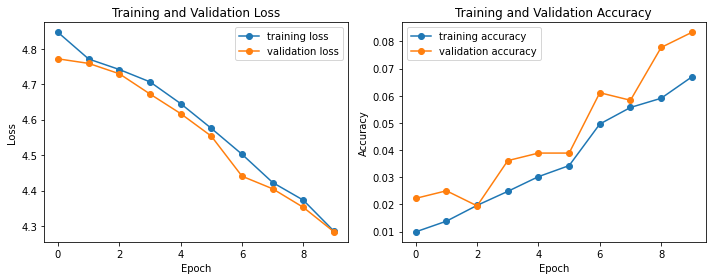

In [89]:
#visualize the loss and accuracy through each epoch
plt.subplots(1,2,figsize =(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], marker='o', label='training loss')
plt.plot(history.history['val_loss'], marker='o', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['acc'], marker='o', label='training accuracy')
plt.plot(history.history['val_acc'], marker='o', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [90]:
base_rate = 1/120
base_rate

0.008333333333333333

The accuracy in the 10th epoch is 8.3% and the base rate in 0.83%. That is 10 times better than randomly choosing a breed for every image. All of that with only 10 epochs! Since there is already a "early stopping" monitoring system, I can use that to my advantage and set the epochs to a very high number (where over fitting would be certain) and the early stop would notice as soon as the validation accuracy stops improving the model will stop running saving me lots of time. So I will do the exact same model and set the epochs to 10,000 with this in mind. 

In [91]:
# Fitting the model to the training data with more epochs
history2 = breed_model.fit(train_generator,
                        steps_per_epoch=train_stepsize,
                        epochs=10000,
                        validation_data=validation_generator,
                        validation_steps=val_stepsize,
                        callbacks=[ES])

Epoch 1/10000
370/370 [==============================] - 138s 373ms/step - loss: 4.2355 - acc: 0.0744 - val_loss: 4.2358 - val_acc: 0.0917
Epoch 2/10000
370/370 [==============================] - 138s 373ms/step - loss: 4.2016 - acc: 0.0799 - val_loss: 4.2436 - val_acc: 0.0861
Epoch 3/10000
370/370 [==============================] - 139s 375ms/step - loss: 4.1475 - acc: 0.0866 - val_loss: 4.1696 - val_acc: 0.0750
Epoch 4/10000
370/370 [==============================] - 141s 380ms/step - loss: 4.1237 - acc: 0.0897 - val_loss: 4.1590 - val_acc: 0.0722
Epoch 5/10000
370/370 [==============================] - 140s 378ms/step - loss: 4.1023 - acc: 0.0877 - val_loss: 4.1163 - val_acc: 0.0833
Epoch 6/10000
370/370 [==============================] - 140s 378ms/step - loss: 4.0554 - acc: 0.0939 - val_loss: 4.1185 - val_acc: 0.0722
Epoch 00006: early stopping


Look at that, it stopped at 15 epochs, so 10,000 was a very generous over estimate. Let's visualize the loss and accuracy like before. 

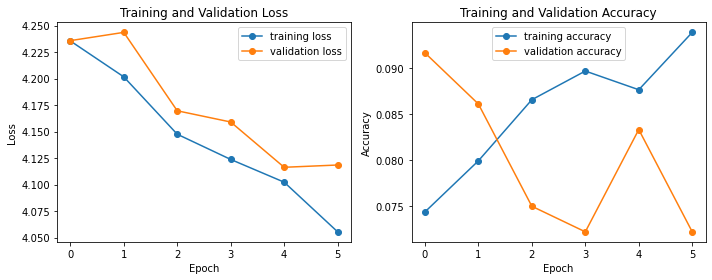

In [92]:
plt.subplots(1,2,figsize =(10,4))

plt.subplot(1,2,1)
plt.plot(history2.history['loss'], marker='o', label='training loss')
plt.plot(history2.history['val_loss'], marker='o', label='validation loss')
plt.title('Training and Validation Loss')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(history2.history['acc'], marker='o', label='training accuracy')
plt.plot(history2.history['val_acc'], marker='o', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

At it highest (9 epochs) this model had an accuracy of 9.17%. In the future I will certainly dive more into this model and connect it more clearly with the tabular data so dog images can be used as input to predict if a dog is adoptable or not. To end this notebook I will evaluate this model using the train data.  

In [93]:
# Instantiating the training/validation ImageDataGenerator()
datagen_train = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   zoom_range=0.1,
                                   shear_range=0.2,
                                   fill_mode='reflect',
                                   validation_split=0.1)

# Generator for the training data, shuffle set to True 
train_generator = datagen_train.flow_from_directory(path+'train/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True, subset='training')

# Generator for validation data, shuffle set to 'False' 
test_generator = datagen_train.flow_from_directory(path+'test/',
                                                    target_size=(pixels, pixels),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True, subset='validation') #changed this to true

# Saving the number of stepsizes for the training, validation and test sets 
train_stepsize = train_generator.samples//train_generator.batch_size    # note integer division operator

test_stepsize = test_generator.samples//test_generator.batch_size 

# Sanity check 
print(f'Training step size = {train_stepsize} \nTest step size = {test_stepsize}')

Found 7401 images belonging to 120 classes.
Found 790 images belonging to 120 classes.
Training step size = 370 
Test step size = 39


In [94]:
test_history = breed_model.fit(train_generator,
                        steps_per_epoch=train_stepsize,
                        epochs=10000,
                        validation_data=validation_generator,
                        validation_steps=val_stepsize,
                        callbacks=[ES])

Epoch 1/10000
370/370 [==============================] - 139s 375ms/step - loss: 4.0189 - acc: 0.0947 - val_loss: 4.0689 - val_acc: 0.0944
Epoch 2/10000
370/370 [==============================] - 139s 376ms/step - loss: 4.0105 - acc: 0.0997 - val_loss: 4.1170 - val_acc: 0.0861
Epoch 3/10000
370/370 [==============================] - 138s 373ms/step - loss: 3.9729 - acc: 0.1093 - val_loss: 4.0667 - val_acc: 0.0889
Epoch 4/10000
370/370 [==============================] - 136s 368ms/step - loss: 3.9406 - acc: 0.1134 - val_loss: 4.0313 - val_acc: 0.1000
Epoch 5/10000
370/370 [==============================] - 142s 385ms/step - loss: 3.9320 - acc: 0.1167 - val_loss: 4.0502 - val_acc: 0.0861
Epoch 6/10000
370/370 [==============================] - 141s 381ms/step - loss: 3.9052 - acc: 0.1120 - val_loss: 4.0166 - val_acc: 0.0833
Epoch 7/10000
370/370 [==============================] - 142s 383ms/step - loss: 3.8965 - acc: 0.1154 - val_loss: 4.0411 - val_acc: 0.0944
Epoch 8/10000
370/370 [====

In [96]:
f"This model is {.10/base_rate} times more accurate at classifying dog breeds than random chance."

'This model is 12.0 times more accurate at classifying dog breeds than random chance.'

There you have it, according to the train/test fitting, the images can be classified with at least 10% accuracy. That's 12 times greater than random chance!